In [1]:
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import evaltools as et, viz_tools
import cmocean as cmo
import datetime as dt
import netCDF4 as nc
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import cmocean

%matplotlib inline

In [2]:
# path to model files:
PATH= '/results/SalishSea/nowcast-green.201812/'

# start and end dates for analysis:
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2016,1,1)

# number of days per model file:
flen=1

# dictionary mapping desired model variables to the file types where they are found
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T',
         'flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}

# dictionary mapping model file types to their time resolution in hours (1 is hourly files, 24 is daily)
fdict={'ptrc_T':1,'grid_T':1}

# results format
# -- nowcast: files like 01jan15/SalishSea_1h_20150101_20150101_ptrc_T.nc
# -- long: files like SalishSea_1h_20150206_20150804_ptrc_T_20150427-20150506.nc, all in one directory
namfmt='nowcast'

# path to directory containing database: 
obsDir='/ocean/shared/SalishSeaCastData/DFO/BOT/'
#(dbname defaults to 'DFO_OcProfDB.sqlite')

In [3]:
# load DFO bottle data (returns pandas dataframe)
# AbsSal is Absolute (actually reference) Salinity, and ConsT is Conservative Temperature
# N is nitrate+nitrate, Si is Silicate; Chlorophyll_Extracted; Z is depth (m); dtUTC is datetime in UTC
# excludeSaanich=True -> do not include data from Saanich Inlet
df1=et.loadDFO(basedir=obsDir,datelims=(start_date,end_date),excludeSaanich=True)
print(len(df1))
df1.head()

569


,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC
0,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,1.9,None,None,None,NaN,mg/m^3,15.31,32.14,umol/L,29.227507,9.859421,1.884,2015-02-11 11:04:07
1,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,6.6,None,None,None,2.57,mg/m^3,17.13,33.90,umol/L,29.484341,9.777243,6.54434,2015-02-11 11:04:07
2,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,6.7,None,None,None,NaN,mg/m^3,NaN,NaN,umol/L,29.484839,9.771987,6.6435,2015-02-11 11:04:07
3,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,11.0,None,None,None,NaN,mg/m^3,NaN,NaN,umol/L,30.144549,9.439995,10.9071,2015-02-11 11:04:07
4,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,11.0,None,None,None,NaN,mg/m^3,20.62,37.65,umol/L,30.157913,9.433733,10.9071,2015-02-11 11:04:07


In [4]:
# match model output to observations and return both in a dataframe
# the model variables will have their original names prefixed by mod_, eg mod_vosaline
# the observation file names are unchanged. 
data=et.matchData(data=df1,filemap=filemap, fdict=fdict, mod_start=start_date, mod_end=end_date, 
                  mod_nam_fmt=namfmt, mod_basedir=PATH, mod_flen=flen)

In [5]:
#Chl:N ratio used later in plots
mod_chl_N=1.7

/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


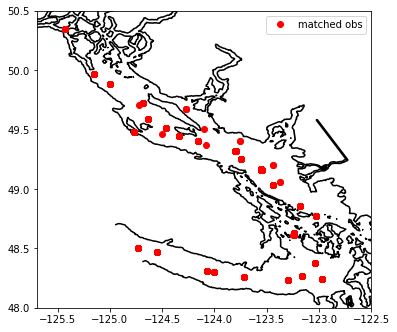

In [6]:
# plot matched data locations
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='matched obs')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

In [7]:
# create dictionary of dataframe views by year
datyr=dict()
yy=np.array([ii.year for ii in data['dtUTC']])
yys=np.unique(yy)
for yr in yys:
    datyr[yr]=data.loc[yy==yr]

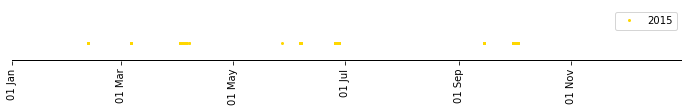

In [8]:
# plot matched data sampling times
clist=('gold','aqua','plum','c','m','r','g','b','brown','gray')
fig,axL=plt.subplots(1,1,figsize=(12,1))
for ii, yr in enumerate(yys):
    dshift=dt.datetime(yys[0],1,1)-dt.datetime(yr,1,1)
    axL.plot(datyr[yr].dtUTC+dshift,np.zeros(np.shape(datyr[yr].dtUTC))+.1*ii,'.',
             color=clist[ii],markersize=4,label=str(yr))
axL.set_yticks(());
yearsFmt = mdates.DateFormatter('%d %b')
axL.xaxis.set_major_formatter(yearsFmt)
axL.xaxis.set_ticks([dt.datetime(int(yys[0]),1,1), dt.datetime(int(yys[0]),3,1),dt.datetime(int(yys[0]),5,1),dt.datetime(int(yys[0]),7,1),
                     dt.datetime(int(yys[0]),9,1),dt.datetime(int(yys[0]),11,1),dt.datetime(int(yys[0])+1,1,1)])
for tick in axL.get_xticklabels():
        tick.set_rotation(90)
        tick.set_horizontalalignment('center')
axL.set_ylim(-.1,.1*(len(datyr.keys())+1))
axL.set_xlim(dt.datetime(yys[0],1,1),dt.datetime(yys[0],12,31))
axL.legend()
axL.set_frame_on(False)
xmin, xmax = axL.get_xaxis().get_view_interval()
ymin, ymax = axL.get_yaxis().get_view_interval()
axL.add_artist(mpl.lines.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

#### Display stats

In [9]:
print('NO3 depth<15:') 
et.printstats(data.loc[data.Z<15,:],'N','mod_nitrate')
print('dSi depth<15:')
et.printstats(data.loc[data.Z<15,:],'Si','mod_silicon')

NO3 depth<15:
  N: 127
  bias: -3.771251214747643
  RMSE: 5.789252127945475
  WSS: 0.8539460770412938
dSi depth<15:
  N: 127
  bias: 3.777340317072831
  RMSE: 8.070655806074383
  WSS: 0.8290339209977697


In [10]:
# chlorophyll calculations
data['l10_obsChl']=np.log10(data['Chlorophyll_Extracted']+0.01)
data['l10_modChl']=np.log10(mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])+0.01)
data['mod_Chl']=mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])
data['Chl']=data['Chlorophyll_Extracted']

### mod vs. obs plots

Text(0.5, 1.0, 'log10[Chl (mg/m3)]')

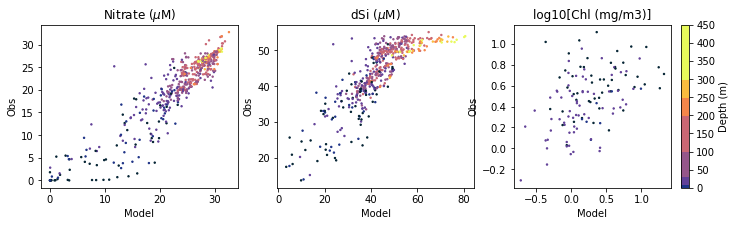

In [11]:
cm1=cmocean.cm.thermal
bounds = np.array([0,5,10,35,100,200,250,300,450])
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#pcm = ax[1].pcolormesh(X, Y, Z1, norm=norm, cmap='RdBu_r')
fig,ax=plt.subplots(1,3,figsize=(12,3))
data['Chlorophyll_Extracted']
args={'marker':'.','s':8,'norm':norm}
ps=et.varvarScatter(ax[0],data,'N','mod_nitrate','Z',cm=cm1,args=args)
ps=et.varvarScatter(ax[1],data,'Si','mod_silicon','Z',cm=cm1,args=args)
ps=et.varvarScatter(ax[2],data,'l10_obsChl','l10_modChl','Z',cm=cm1,args=args)

cb=fig.colorbar(ps,ax=ax[2],boundaries=np.linspace(0,450,46))
cb.set_label('Depth (m)')
for iax in ax:
    iax.set_xlabel('Model')
    iax.set_ylabel('Obs')
ax[0].set_title('Nitrate ($\mu$M)')
ax[1].set_title('dSi ($\mu$M)')
ax[2].set_title('log10[Chl (mg/m3)]')

